# Advice AI
Authors: Swag, Zaki, Brandon

## Load the data
<a name="advice-data"></a>
### Advice Data
We have two advice datasets:
- **heyfromthefuture**: Advice taken from [heyfromthefuture.com](https://heyfromthefuture.com/) with permission. It contains life advice categorized by age.
- **randomstuffifound**: Literally random advice I found on Google. It is miscellaneous advice on miscellaneous topics.

We filtered both these datasets of any explicit or harmful content, and modified them to ensure correct grammar.

In [1]:
import hashlib, json
# helper method to load a json file and check it's hash
# throws an assertion error if the hashes don't match
# This ensures we use the same data across multiple iterations of this notebook
def load_json_and_check_hash(json_file, expected_hash):
  with open(json_file, 'r') as f:
    raw_data = f.read()
  hash = hashlib.sha3_256(raw_data.encode()).hexdigest()
  assert hash == expected_hash, "{} does not have the correct hash and was likely modified. Expected '{}' got '{}'".format(json_file, expected_hash, hash)
  return json.loads(raw_data)

In [2]:
# Load the advice datasets
heyfromthefuture = load_json_and_check_hash('heyfromthefuture.json', 'f20a5434e20f425ba7dc8dea364baa81c16ddac1154d01110f045162a4d11ad5')
randomstuffifound = load_json_and_check_hash('randomstuffifound.json', '1a7a0e702809e3b138db7da4f5e58626a9ebdb71149d43ac3f3143a57cc7bdf3')

<a name="load-the-model"></a>
## Load the model
We used Tensorflow's [Universal Sentence Encoder QA](https://tfhub.dev/google/universal-sentence-encoder-qa/3) model for our task. This was the best solution we found during our inital research

In [ ]:
!pip install tensorflow_text

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

# Load the model
module = hub.load('https://tfhub.dev/google/universal-sentence-encoder-qa/3')

## Encode Advice
Since the model is entirely deterministic [as we show below](#showing-determinism) we can use this method to encode the advice just once and use the encodings repeatedly

In [5]:
# Helper method to turn data into advice and contexts
#   `data` is a dataset
#   `to_advice` is a function that turns a line in that dataset into an advice string
#   `to_context` is a function that turns a line in that dataset into a context
# This is to let us see what substrings best serve as contexts in our models later on
def to_advice_and_contexts(data, to_advice, to_context):
  return [to_advice(p) for p in data], [to_context(p) for p in data]

# Encodes advice and returns it
def encode_advice(advice, contexts):
  return module.signatures['response_encoder'](
    input = tf.constant(advice),
    context = tf.constant(contexts))['outputs']

<a name="showing-determinism"></a>
#### Showing Determinism
We show determinism by encoding the advice for the randomstuffifound dataset twice and comparing the results

In [6]:
# Generate advice and contexts. This is trivially determinstic so we do it once
det_adv, det_ctx = to_advice_and_contexts(randomstuffifound, lambda x: x, lambda x: x)
# Do two 'trials' of encoding the randomstuffifound dataset
det_trial_1 = encode_advice(det_adv, det_ctx)
det_trial_2 = encode_advice(det_adv, det_ctx)
# Check if they're the same
if tf.math.reduce_all(tf.equal(det_trial_1, det_trial_2)):
  print('Determinism holds!')
else:
  print('Determinism is false!')

Determinism is false!


## Make Queries
We encode queries and take the dot product to determine a "relevancy score" between each query and advice. Then we use a heap to get the top n advice

In [7]:
# Use this to get the top n advice
import heapq
# Computes "the best" advice for multiple queries
#   `queries` is a list of query strings
#   `advice` is the list of advice strings
#   `encoded_advice` is the encoded advice (See `encode_advice` above)
# Returns a dict of the form {query: [(score, advice)]}
def ask(queries, advice, encoded_advice, top_n=1):
  encoded_queries = module.signatures['question_encoder'](tf.constant(queries))['outputs']
  weights = np.inner(encoded_queries, encoded_advice)
  return {q:heapq.nlargest(top_n, zip(weights[i], advice)) for i, q in enumerate(queries)}

<a name="a-demo"></a>
### A Demo
Below is a simmilar demo to what we made during [data collection](#data-collection-methodology)

We load both datasets and collect them in a pool in essentially the same way as in the [tfjs version](#advice-encoding)

In [8]:
# heyfromthefuture
hftf_adv, hftf_ctx = to_advice_and_contexts(heyfromthefuture, lambda x: x[17:], lambda x: x)
# randomstuffifound
rsif_adv, rsif_ctx = to_advice_and_contexts(randomstuffifound, lambda x: x, lambda x: x)

# We combine both advice and context into a pool for the demo
demo_adv, demo_ctx = [*hftf_adv, *rsif_adv], [*hftf_ctx, *rsif_ctx]
# And finally generate encodings
demo_encode = encode_advice(demo_adv, demo_ctx)

Try it out! Ask any query and the number of responses you would like to get advice and their scores!

In [9]:
# We import pandas here to pretty print the table
import pandas as pd
my_query = input('What qualms you:')
my_advice = ask([my_query], demo_adv, demo_encode, top_n=int(input('How many advice would you like:')))
# Print the results and dont truncate anything
with pd.option_context('display.max_colwidth', None):
  display(pd.DataFrame(my_advice[my_query], columns=['Score', 'Advice']))

What qualms you:I don't feel satisfied with this project
How many advice would you like:10


,Score,Advice
0,0.136927,Words have more power than you think - Say 'There is a problem with the project' compared to 'There's an opportunity to make the project better'. Which one sounds better?
1,0.109688,"Be prepared: When you are 90% done any large project (a house, a film, an event, an app) the rest of the myriad details will take a second 90% to complete."
2,0.105888,"Focus on making an impact - Make your work meaningful and if your work isn't, do something about it. Ask yourself 'If this was my last day, would I feel content?'"
3,0.099166,"At this age, you are furious, you wanna do everything, perfectly, quickly, you think the time is running out. I just want you to know that it's okay, you are very young, take your time, grow yourself, it's okay"
4,0.095581,"take a step back and look at yourself. Are you sacrificing all your progress to just settle for something like ""comfort"" or ""familiarity""?"
5,0.094906,Take initiative - I've had problems with this and that's making an impact without being told what to do. This separates successful from the mediocre
6,0.092117,"Your feelings are valid! Get a friend who will listen to them, and remember to LISTEN TO THIERS TOO!!!"
7,0.088407,By now you have probably failed at something. You have to pick yourself up and know that there are better things in store. Valuable lessons come from things that don't work. Get back on the damn horse already and try something different
8,0.087341,"if you tell yourself what you're feeling is just stress, or holiday blues, or vitamin deficiency, or hormonal imbalance, but the feeling doesn't go away, it might be depression, and it's ok to run that by a mental health professional. Now"
9,0.084406,"You probably feel confused about who you are and how you feel. This is completely normal - you don't need to worry. Allow yourself to feel these things, and life will sort itself out with time"


<a name='analysis'></a>
# Analysis?

<a name="qa-data"></a>
## QA Data
We also collected **our own** question-answer data from [a demo we ran](https://swag-site.herokuapp.com/helpful). You can find our methodology [below](#data-collection-methodology)

It contains the questions asked by users as well as the answers they considered, in order, before leaving the site.

With privacy being a concern, **you should not have access to this data**. Please let us know if you do.

In [10]:
# Load the QA dataset
qa_data = load_json_and_check_hash('4-16-21_qa_data.json', 'bfc28fab622f7762a2f2c1193071394ace95c4ebdaa1c01278a0e6d4be302cd2')
# Because we often need just the questions
q_data = [e['question'] for e in qa_data]

<a name="compare-tf-and-tfjs"></a>
## Comparing TF and TFJS
Since the [qa_data](#qa-data) contains questions as well as advice generated by the [tfjs model](#data-collection-methodology), we can compare the two models by generating advice for the same questions using the [python model](#a-demo) here.

In [11]:
# Compute the advice for all the same questions now with the python model
# topn is 50 here because in the tfjs demo we capped the number of advice generated to 50
tf_qa_data = ask(q_data, demo_adv, demo_encode, top_n=50)

Since we are using pandas for plotting, we move our data into a dataframe.

We also preserve the number of the advice for each question. e.g. whether this was the first or fifth advice the user saw.

Lastly we add a column of random advice to act as a control in simmilarity calculations

In [12]:
# We use these to categorize the data for plots
cmp_df = pd.DataFrame(columns=['tfjs', 'tf'])
# Fill up the pools
for entry in qa_data:
  n_asks = len(entry['responses'])
  cmp_df = cmp_df.append(pd.DataFrame({
    'tfjs': entry['responses'],
    'tf': [advice for score, advice in tf_qa_data[entry['question']][:n_asks]]
  }))
# Because of the way we append rows the index actually becomes the nth ask
cmp_df['n_asks'] = cmp_df.index + 1
# We also make a random column with random advice to act as a control
cmp_df['rand'] = np.random.choice(demo_adv, size=len(cmp_df.index))

<a name="**use-v4**"></a>
We use Tensorflow's [Universal Sentence Encoder v4](https://tfhub.dev/google/universal-sentence-encoder/4) model to determine simmilarity. We load this model using the same tensorflow hub module as [the other USE model](#load-the-model)

In [13]:
# Load the USE v4 model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

We define a function to compute the simmilarity between two given columns and graph a box plot.

This is to ensure the experiment and control run through the exact same function.

In [14]:
import pandas as pd
def compute_and_plot_simmilarity(df, col1, col2, title):
  ax = pd.DataFrame({
    # Compute simmilarity via dot product
    'simmilarity': np.inner(embed(df[col1]), embed(df[col2])).diagonal(),
    'n_asks': df['n_asks']
  }).boxplot(
    column='simmilarity',
    by='n_asks', # We make a seperate plot for eack ask
    figsize=(25, 5),
    showmeans=True, # Show the means as green triangles
    patch_artist=True
  )
  ax.set_ybound(0, 1) # To maintain y scaling across multiple plots
  ax.set_xlabel('the nth ask')
  ax.set_ylabel('simmilarity')
  ax.set_title(title)

Below is the comparison of the tfjs model and the tf model. Notice the answers are more simmilar early on but slowly diverge. There are quite a few answers that were a perfect match and the average simmilarity seems to be about $30\%$

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


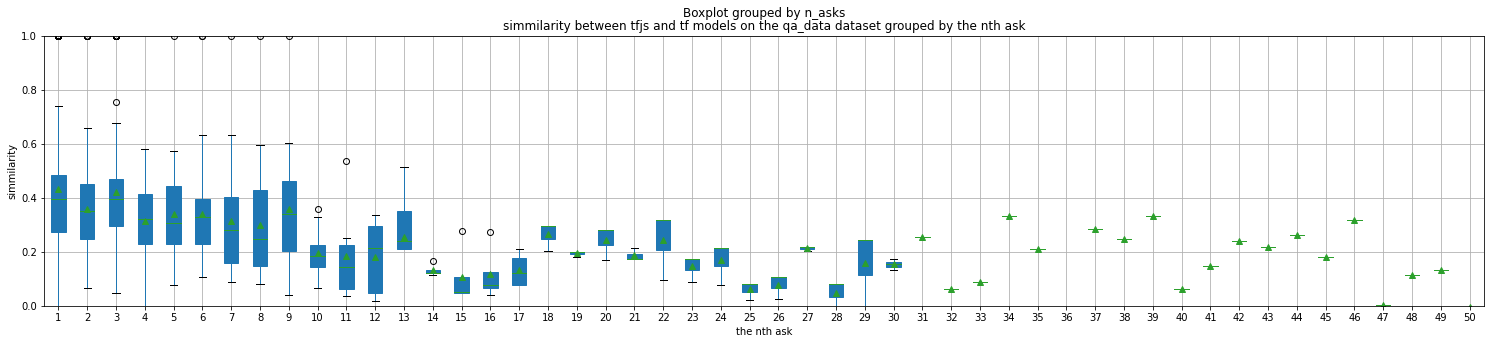

In [15]:
compute_and_plot_simmilarity(cmp_df, 'tfjs', 'tf', 'simmilarity between tfjs and tf models on the qa_data dataset grouped by the nth ask')

Below is the comparison of the tfjs model and random data. Notice that similarity is about $0.2$ and it holds constant throughout any number of asks. There are no cases of a perfect match.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


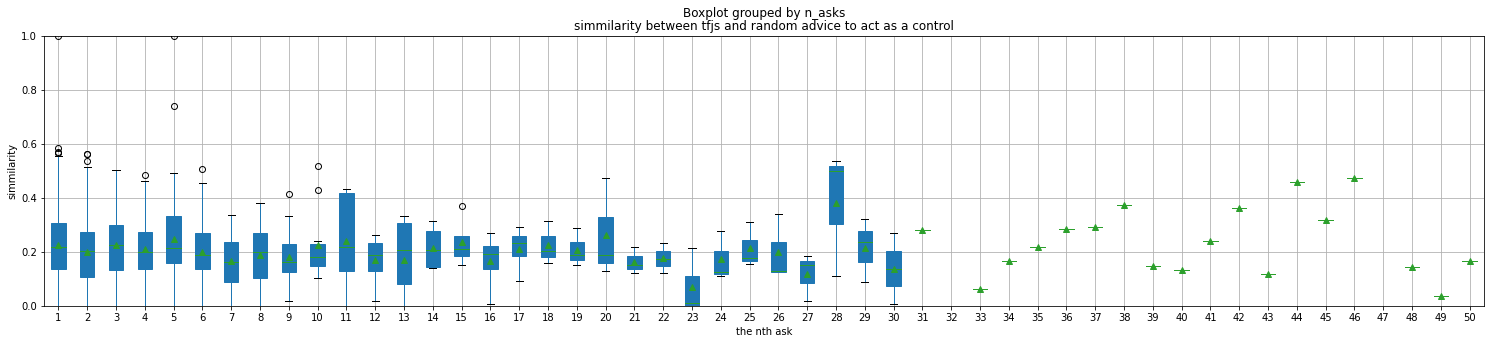

In [16]:
compute_and_plot_simmilarity(cmp_df, 'tfjs', 'rand', 'simmilarity between tfjs and random advice to act as a control')

<a name="advice-comparison"></a>
## Advice Comparison
We take a look at the simmilarity profile of advice in our [combined dataset](#a-demo) to get a sense of it's diversity.

We use the same USE v4 [as above](#use-v4) to accomplish this.

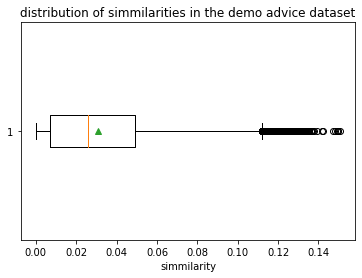

In [17]:
# Use the USE to generate embeddings
vects = embed(demo_adv)
# Take dot product to calculate simmilarites
mat = np.inner(vects, vects)
# Get unique simmiarities by flattening the lower triangle
# Take absolute value because some are negative but simmilarity is not
unique_sim = np.absolute(np.tril(vects, -1).flatten())
# Plot it
import matplotlib.pyplot as plt
plt.boxplot(unique_sim, vert=False, showmeans=True)
plt.xlabel('simmilarity')
plt.title('distribution of simmilarities in the demo advice dataset')
plt.show()

This shows we acually have a really diverse dataset with the most simmilar advice being only around 14% simmilar and the average being less than 3%. 

## Question Comparison
We can apply the same analysis as [above](#advice-comparison) to the questions in [qa_data](#qa-data)

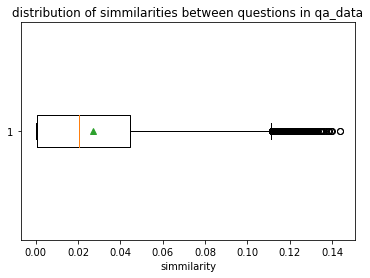

In [18]:
vects = embed(q_data)
mat = np.inner(vects, vects)
unique_sim = np.absolute(np.tril(vects, -1).flatten())
plt.boxplot(unique_sim, vert=False, showmeans=True)
plt.xlabel('simmilarity')
plt.title('distribution of simmilarities between questions in qa_data')
plt.show()

Again this shows we have a really diverse selection of questions. Intrestingly the distribution is **nearly identical** to our distribution of advice. We're not quite sure why this is and *may point to a larger phenomenon*

<a name="n_asks"></a>
## Number of Asks
We were intrested in the distribution of asks to act as a measure of accuracy for our model

The accuracy rate is 84%


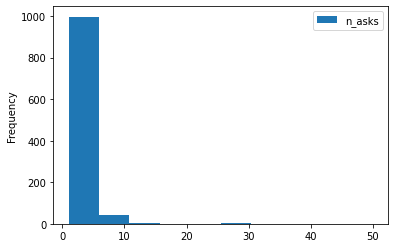

In [19]:
# Get number of asks for each user
asks_df = pd.DataFrame({'n_asks': [len(e['responses']) for e in qa_data]})
# histogram
asks_df.plot.hist(by='n_asks')
# Calculate accuracy
# percentage of accurate responses where n_asks=1
percent_accurate = asks_df['n_asks'].value_counts(normalize=True)[1]
print('The accuracy rate is {}%'.format(round(percent_accurate * 100)))

In [20]:
# Below, the normalized distribution of n_asks is shown for the top 13 counts.
asks_df['n_asks'].value_counts(normalize=True)[:13]

1     0.840191
2     0.043062
4     0.030622
3     0.026794
5     0.013397
6     0.012440
7     0.008612
8     0.007656
9     0.006699
10    0.003828
13    0.001914
50    0.000957
30    0.000957
Name: n_asks, dtype: float64

If we assume users that left the site after reading just the first advice they recieved, recieved good advice, then our model's accuracy is just over $84\%$ accurate

<a name="comparing-advice-datasets">
## Comparing Advice Datasets

We were interested in which advice dataset produced the most accurate advice on average

In [21]:
# Encode our datasets seperately
hftf_encode = encode_advice(hftf_adv, hftf_ctx)
rsif_encode = encode_advice(rsif_adv, rsif_ctx)

In [22]:
# Helper method to extract just the scores from a call to the `ask` function
def get_scores(ask_response):
  return [a[0][0] for a in ask_response.values()]

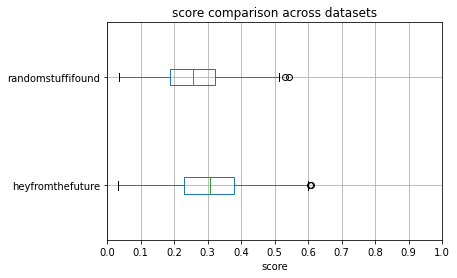

In [23]:
dataset_comp_ax = pd.DataFrame({
  'heyfromthefuture': get_scores(ask(q_data, hftf_adv, hftf_encode)),
  'randomstuffifound': get_scores(ask(q_data, rsif_adv, rsif_encode))
}).boxplot(vert=False)
dataset_comp_ax.set_xticks([n/10 for n in range(10+1)])
dataset_comp_ax.set_xlabel('score')
_=dataset_comp_ax.set_title('score comparison across datasets')

As you can see the heyfromthefuture dataset performs slightly better than the randomstuffifound dataset. This is actually surprising as the heyfromthefuture dataset is more than twice as large.

We don't think the quality of the advice in the datasets is much different and so this likely points to diminishing returns of adding more advice.

## Scores of Irrelevant Advice
We were intrested in how confident the model was when it was "wrong" a.k.a. when the user clicked Ask Again!

Unfortunately we didn't collect that data at the time so we decided based on [our comparison results](#compare-tf-and-tfjs) that the python model serves as a good analog.

Here's the idea:
1. split questions based on whether the user had to click Ask Again
2. ask the Python model to answer the questions
3. compare the distributions

In [24]:
# split questions based on whether the user had to click Ask Again
q_success, q_fail = [], []
for e in qa_data:
  if len(e['responses']) == 1:
    q_success.append(e['question'])
  else:
    q_fail.append(e['question'])

The `get_scores` method below is from [the last analysis](#comparing-advice-datasets)

In [25]:
# Calculate scores
success_scores = get_scores(ask(q_success, demo_adv, demo_encode))
fail_scores = get_scores(ask(q_fail, demo_adv, demo_encode))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


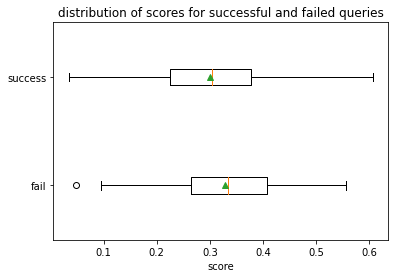

In [26]:
# Plot them
plt.boxplot([fail_scores, success_scores], labels=['fail', 'success'], vert=False, showmeans=True)
plt.xlabel('score')
plt.title('distribution of scores for successful and failed queries')
plt.show()

Interestingly, the model seemed to be more confident when it failed. 

# Making Improvements
Based on our [analysis](#analysis) we came up with a few methods of improving the AI to provide more relevant advice
- Fine tune the USE QA Model
- Fine tune advice contexts
- Cull advice to create a more performant dataset
- Add more advice to the dataset

Of these we hypothesize fine-tuning the USE QA Model will be most effective, and perhaps we can use some combination for maximum benefits

**This is where we left off in this project as we ran out of time.** You can see our attempt at tuning the USE-QA model [here](#fine-tuneing)

# Footnotes
The *details*

<a name="data-collection-methodology"></a>
## Data Collection Methodology
We collected QA using a demo of this AI we launched at [swag-site.herokuapp.com/helpful](https://swag-site.herokuapp.com/helpful).

### Software Used
The demo web-app is written in [Node.js](https://nodejs.org/en/) and using [the Tensorflow-JS variant of the Universal Sentence Encoder QA model](https://github.com/tensorflow/tfjs-models/tree/master/universal-sentence-encoder).

**Note the Tensorflow-JS model is different from the Tensorflow model used in this notebook.** We used the TF-JS model for our demo as we deemed the standard TF model infeasible for a production environment.
```javascript
require('@tensorflow/tfjs')
const use = require('@tensorflow-models/universal-sentence-encoder')
const model = use.loadQnA()
```
We used Node's `fs` to load our data.
```javascript
const fs = require("fs")
```

<a name="advice-encoding"></a>
### Then we load [the advice](#advice-data)
- For the randomstuffifound dataset we use the advice for both response and context
- For the heyfromthefuture dataset we use the advice as context but remove the "Hey xx year old, " from the beginning of every response. This is to generalize the advice for the user while keeping it contexualized for the AI.

```javascript
const [heyfromthefuture, randomstuffifound] = ["./src/assets/heyfromthefuture.json", "./src/assets/randomstuffifound.json"]
  .map(path => JSON.parse(fs.readFileSync(path)))

const advice = {
  responses: [...heyfromthefuture.map(v => v.slice(17)), ...randomstuffifound],
  contexts: [...heyfromthefuture, ...randomstuffifound]
}
```

### Generating Embeddings
We also used `fs` to cache advice embeddings and reduce overhead on app start-time. We figured since the model is entirely determinsitc and advice is embedded independant to questions, that this wouldn't cause any isses.
```javascript
const cache_file = "./src/assets/a_embed.json"
const advice_embeddings = new Promise((res) => fs.readFile(cache_file, (err, data) => {
  // If we had an error while reading (probably because it was missing)
  if (err) {
    console.log("helpful_api: advice embeddings not found. generating now. this will take a long time")
    model.then(m =>
      // Embed the advice as responses and contexts. Get the embeddings. Convert the tensor to js array.
      m.embed({ queries: [], responses: advice.responses, contexts: advice.contexts })["responseEmbedding"].arraySync()
    ).then(a_embed => {
      // Cache the embeddings as json
      fs.writeFile(cache_file, JSON.stringify(a_embed), () => console.log("embeddings cached successfully"))
      // Return the embeddings
      res(a_embed)
    })
  } else {
    // Return the embeddings
    res(JSON.parse(data))
  }
}))
```

<a name="relevancy-scores"></a>
### The Advice AI
We made the following function to take a question and return a relevancy score for every line of advice in both datasets. This is where the magic happens
```javascript
const zipWith = (f, xs, ys) => {
  const ny = ys.length
  return (xs.length <= ny ? xs : xs.slice(0, ny)).map((x, i) => f(x, ys[i]))
}

const dotProduct = (xs, ys) => {
  const sum = xs => xs ? xs.reduce((a, b) => a + b, 0) : undefined
  return xs.length === ys.length ? sum(zipWith((a, b) => a * b, xs, ys)) : undefined
}

module.exports.get_advice = async (question) => {
  // Get the model
  const m = await model
  // Get the advice embeddings
  const a_embed = await advice_embeddings
  // Embed the question. Get the embeddings. Convert tensor to js array.
  // Get the first element because there's only one question.
  const q_embed = m.embed({ queries: [question], responses: [] })['queryEmbedding'].arraySync()[0]
  // Now that we have the embeddings we do the dot product!
  let relavance = {}
  for (let i = 0; i < advice.responses.length; i++) {
    // For each advice compute relevance via the dot product
    relavance[advice.responses[i]] = dotProduct(q_embed, a_embed[i])
  }
  return relavance
}
```

### Data Collection
We store our data in a postgres database table with the following structure
```sql
CREATE TABLE helpful_data (
  question text NOT NULL,
  n_asks int NOT NULL,
  ask_time timestamp NULL DEFAULT CURRENT_TIMESTAMP
  id SERIAL PRIMARY KEY
);
```
To understand our data collection it helps to understand the workings of the demo

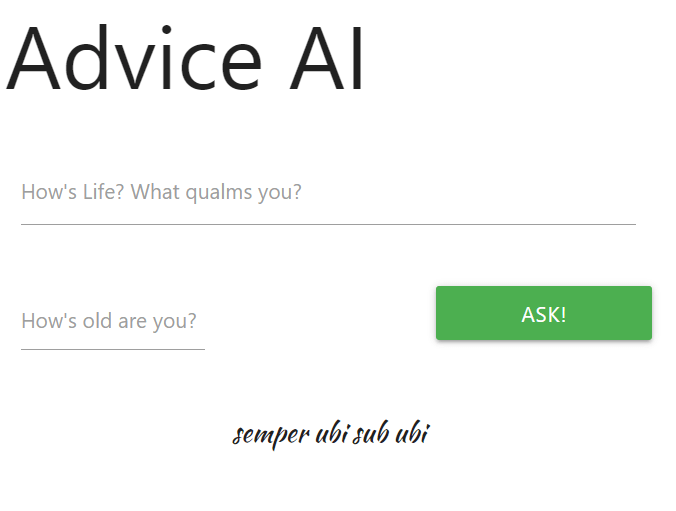

When the user clicks ASK! the following method is called on the server. To handle ages we simply append "I am x years old" to the beginning of their question.
```javascript
module.exports.log = (question) => {
  pool.connect().then(client => {
    return client
      .query("INSERT INTO helpful_data (question, n_asks) VALUES ($1, $2)", [question, 1])
      .then(res => client.release())
      .catch(err => {
        client.release()
        console.log(err.stack)
      })
  })
}
```
and the website displays the most relevant advice according to the relevancy scores [we mentioned before](#relevancy-scores)

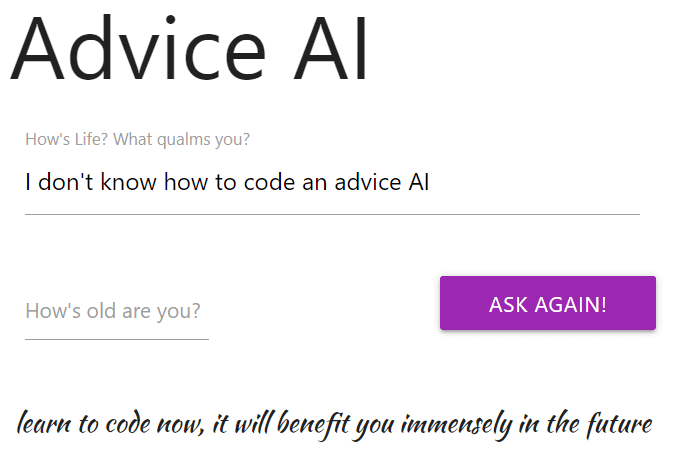

Notice that the ASK! button has turned into an ASK AGAIN! button. When the user presses this it displays the next most relevant advice, and then the next most, and so on.

Additionally everytime this button is pressed the following method is called on the server.

```javascript
module.exports.update = (question) => {
  pool.connect().then(client => {
    return client
      .query("UPDATE helpful_data SET n_asks=n_asks+1 WHERE id=(SELECT id FROM helpful_data WHERE question=$1 ORDER BY ask_time DESC LIMIT 1)", [question])
      .then(res => client.release())
      .catch(err => {
        client.release()
        console.log(err.stack)
      })
  })
}
```
This ensures the `n_asks` variable in the database encodes the number of times the user asked that specific question.

### Retrieving Data
Once we had ~1000 responses from the database we downloaded a json representation of our table as `4-16-21_snapshot.json`. We then ran the following code to convert it into a dictionary of questions asked by users and the advice they recieved in order.
```javascript
const snap = JSON.parse(fs.readFileSync("src/4-16-21_snapshot.json"))
const dat = snap.values.map(([q, n]) => module.exports.get_advice(q).then(advice => {
  sorted = Object.keys(advice).sort((a, b) => advice[b]-advice[a])
  return {question: q, responses: sorted.slice(0, n)}
}))
Promise.all(dat).then(arr => {
  fs.writeFileSync("4-16-21_qa_data.json", JSON.stringify(arr))
})
```
This is what we refer to as the [QA Dataset](#qa-data) we collected

```javascript
const snap = JSON.parse(fs.readFileSync("src/4-16-21_snapshot.json"))
const dat = snap.values.map(([q, n]) => module.exports.get_advice(q).then(advice => {
  sorted = Object.keys(advice).sort((a, b) => advice[b]-advice[a])
  return {question: q, responses: sorted.slice(0, n)}
}))
Promise.all(dat).then(arr => {
  fs.writeFileSync("4-16-21_qa_data.json", JSON.stringify(arr))
})
```

## Bootstrap Attempt
There are only $1045$ data points in [qa_data](#qa-data) and we can't show you any of them. To fix at least one of these we tried bootstrapping our data. We tried this via [Vamsi's Paraphrase Generator with T5](https://github.com/Vamsi995/Paraphrase-Generator)
```python
# We load it via HuggingFace's Transformers library
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# Load the Paraphraser
tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")  
model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws")
```
Then we defined a method to paraphrase any given text input
```python
def paraphrase(text, n_samples=1):
  # Encode the text
  encoded = tokenizer.encode_plus(
    'paraphrase: {} </s>'.format(text),
    return_tensors='pt',
    padding=True
  )
  # Generate the outputs
  outputs = model.generate(
    input_ids=encoded['input_ids'],
    attention_mask=encoded['attention_mask'],
    max_length=256,
    do_sample=True,
    top_k=200,
    top_p=0.95,
    early_stopping=True,
    num_return_sequences=n_samples
  )
  # Decode the outputs and return
  return [tokenizer.decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True) for out in outputs]
```
And we did a quick sanity check
```python
paraphrase('I am depressed about my dog', 10)
```
Which resulted in
```
["I'm depressed about my dog.",
 'I am depressed about my dog.',
 'I am depressed about my dog.',
 'I am depressed about my dog.',
 'I am depressed over my dog.',
 'I am depressed about my dog.',
 'I am depressed by my dog.',
 'Forget me, I am depressed about my dog.',
 'I am depressed about my dog.',
 'Ich am depressed over my dog.']
```
And made us immedietly stop this endeavour

## Creating Python API for Model
In order to increase the runtime of the model we were going to create another web application that ran in Python in order to use the most efficient form of the tensor flow model.

Below we can see some example output of that API.

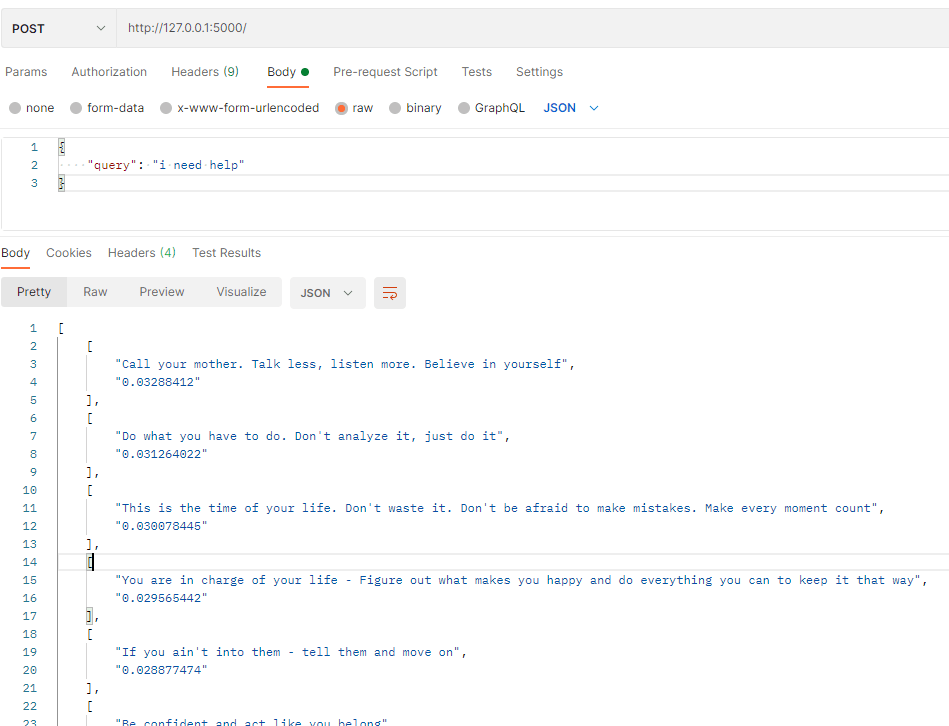

Here we can see a test of the development API where it takes a POST request with the JSON query “I need help” and returns the model’s output in JSON. This includes but is not limited to the top 10 results from the database along with the relative score. 

Unfortunately once we reached the deployment stage we found that the hardware used  (E5-2680 CPU) is too old for the Tensorflow model and this had to be scrapped as the only other option would be to downgrade the model which would both decrease the performance and accuracy. Ultimately, this problem defeated the purpose of having a separate API for speeding up the model

Below is a screenshot of the issue

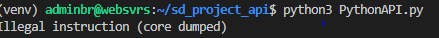

And below is the code we used for the API
```python
import flask
from flask import request, jsonify
 
import json
 
from Q_and_A import ask
 
 
app = flask.Flask(__name__)
app.config["DEBUG"] = True
 
 
 
@app.route('/', methods=['GET'])
def home():
    return "<h1>Distant Reading Archive</h1><p>This site is a prototype API for distant reading of science fiction novels.</p>"
 
@app.route('/', methods=['POST'])
def get_data():
    if not request.json or not 'query' in request.json:
        return "Error: No id field provided. Please specify an query."
        abort(400)
    else:
       results = ask(request.json["query"])
       
       
 
 
    # Use the jsonify function from Flask to convert our list of
    # Python dictionaries to the JSON format.
    n = 10
    print(type(results))
 
    return jsonify(results[:n])
 
app.run()
 
 
if __name__ == "Main":
    print("hello world")
```

<a name="fine-tuneing"></a>
## Fine-Tuning the Model

We tried to fine-tune the model but couldn't get it to work in time. Our training data completely messed up the weights. Below is the code we used
```python
model = tf.keras.Sequential([
  hub.KerasLayer(module, input_shape=[], dtype=tf.string, trainable=True)
])
```
To measure performance we made the assumption that the last piece of advice a user recieved in `qa_data` is the advice they expected
```python
a_data = [e['responses'][-1] for e in qa_data]
true_vals = module.signatures['question_encoder'](tf.constant(a_data))['outputs']
```
We used `model.fit` to tune the model. Below is that code as well as the output of training
```python
model.fit(
    x=tf.constant(q_data),
    y=compare,
    epochs=20,
    validation_split=0.1
)
```
```
Epoch 1/20
30/30 [==============================] - 68s 364ms/step - loss: -2.3807e-06 - binary_accuracy: 0.0000e+00 - val_loss: -2.6834e-05 - val_binary_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 6s 186ms/step - loss: -3.9893e-05 - binary_accuracy: 0.0000e+00 - val_loss: -5.4625e-05 - val_binary_accuracy: 0.0000e+00
Epoch 3/20
30/30 [==============================] - 6s 187ms/step - loss: -6.5641e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.0527e-05 - val_binary_accuracy: 0.0000e+00
Epoch 4/20
30/30 [==============================] - 6s 186ms/step - loss: -6.5619e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.1459e-05 - val_binary_accuracy: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 6s 185ms/step - loss: -6.6076e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.1759e-05 - val_binary_accuracy: 0.0000e+00
Epoch 6/20
30/30 [==============================] - 6s 186ms/step - loss: -6.6957e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.1890e-05 - val_binary_accuracy: 0.0000e+00
Epoch 7/20
30/30 [==============================] - 6s 185ms/step - loss: -7.2910e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.1958e-05 - val_binary_accuracy: 0.0000e+00
Epoch 8/20
30/30 [==============================] - 6s 184ms/step - loss: -7.0944e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2004e-05 - val_binary_accuracy: 0.0000e+00
Epoch 9/20
30/30 [==============================] - 6s 186ms/step - loss: -6.9568e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2038e-05 - val_binary_accuracy: 0.0000e+00
Epoch 10/20
30/30 [==============================] - 6s 186ms/step - loss: -6.8461e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2063e-05 - val_binary_accuracy: 0.0000e+00
Epoch 11/20
30/30 [==============================] - 6s 186ms/step - loss: -7.0408e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2083e-05 - val_binary_accuracy: 0.0000e+00
Epoch 12/20
30/30 [==============================] - 6s 186ms/step - loss: -6.8516e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2099e-05 - val_binary_accuracy: 0.0000e+00
Epoch 13/20
30/30 [==============================] - 6s 187ms/step - loss: -6.8834e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2112e-05 - val_binary_accuracy: 0.0000e+00
Epoch 14/20
30/30 [==============================] - 6s 184ms/step - loss: -6.9079e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2122e-05 - val_binary_accuracy: 0.0000e+00
Epoch 15/20
30/30 [==============================] - 6s 186ms/step - loss: -6.9597e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2130e-05 - val_binary_accuracy: 0.0000e+00
Epoch 16/20
30/30 [==============================] - 6s 184ms/step - loss: -7.0504e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2137e-05 - val_binary_accuracy: 0.0000e+00
Epoch 17/20
30/30 [==============================] - 6s 185ms/step - loss: -7.0547e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2143e-05 - val_binary_accuracy: 0.0000e+00
Epoch 18/20
30/30 [==============================] - 6s 188ms/step - loss: -7.2007e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2149e-05 - val_binary_accuracy: 0.0000e+00
Epoch 19/20
30/30 [==============================] - 6s 185ms/step - loss: -7.1259e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2153e-05 - val_binary_accuracy: 0.0000e+00
Epoch 20/20
30/30 [==============================] - 6s 185ms/step - loss: -7.1205e-05 - binary_accuracy: 0.0000e+00 - val_loss: -6.2157e-05 - val_binary_accuracy: 0.0000e+00
<tensorflow.python.keras.callbacks.History at 0x7f278b659350>
```